NLP ANALYSIS

In [39]:
import gzip
import math
import matplotlib.pyplot as plt
import numpy
import random
import sklearn
import string
from collections import defaultdict
# from gensim.models import Word2Vec
from nltk.stem.porter import *
from sklearn import linear_model
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd

In [20]:
def parseData(fname):
    for l in open(fname):
        yield eval(l)

In [78]:
data = list(parseData("australian_user_reviews.json"))
test = data[:2500] # due to long processing time, we will only select first 2500 samples for this analysis

In [126]:
len(data)

25799

In [30]:
test[0]

{'user_id': '76561197970982479',
 'user_url': 'http://steamcommunity.com/profiles/76561197970982479',
 'reviews': [{'funny': '',
   'posted': 'Posted November 5, 2011.',
   'last_edited': '',
   'item_id': '1250',
   'helpful': 'No ratings yet',
   'recommend': True,
   'review': 'Simple yet with great replayability. In my opinion does "zombie" hordes and team work better than left 4 dead plus has a global leveling system. Alot of down to earth "zombie" splattering fun for the whole family. Amazed this sort of FPS is so rare.'},
  {'funny': '',
   'posted': 'Posted July 15, 2011.',
   'last_edited': '',
   'item_id': '22200',
   'helpful': 'No ratings yet',
   'recommend': True,
   'review': "It's unique and worth a playthrough."},
  {'funny': '',
   'posted': 'Posted April 21, 2011.',
   'last_edited': '',
   'item_id': '43110',
   'helpful': 'No ratings yet',
   'recommend': True,
   'review': 'Great atmosphere. The gunplay can be a bit chunky at times but at the end of the day this 

In [79]:
r_ls = [] # full review_list
for i in test:
    rev_ls=i['reviews']
    id_=i['user_id']
    for w in rev_ls:
        rec=w['recommend']
        review=w['review']
        r=(id_,rec,review)
        r_ls.append(r)
r_ls[0] 

('76561197970982479',
 True,
 'Simple yet with great replayability. In my opinion does "zombie" hordes and team work better than left 4 dead plus has a global leveling system. Alot of down to earth "zombie" splattering fun for the whole family. Amazed this sort of FPS is so rare.')

In [80]:
review_df=pd.DataFrame(r_ls, columns=["User ID","Recommend","Review"])

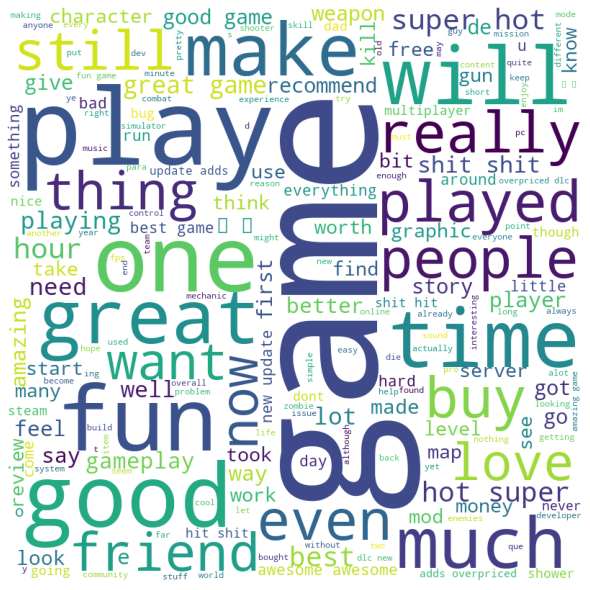

In [81]:
comment_words = ''
stopwords = set(STOPWORDS)
# iterate through the csv file
for val in review_df.Review:
    # typecaste each val to string
    val = str(val)
    # split the value
    tokens = val.split()
    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
    comment_words += " ".join(tokens)+" "
 
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

In [133]:

import nltk
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
def pre_process(sentence):
    new=re.sub(r"[^a-zA-Z0-9 ]", "", sentence)
    new=new.lower()
    return new

review_df['Review']=review_df.apply(lambda row: pre_process(row['Review']), axis=1)
review_df['Word Length']=review_df.apply(lambda row: len(row['Review'].split(' ')), axis=1)

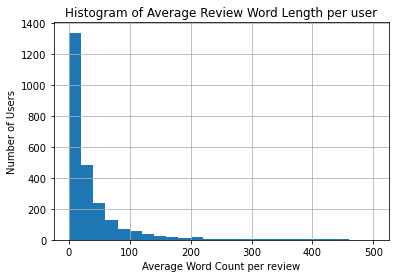

In [95]:
word_length_df=review_df.groupby(['User ID']).mean()['Word Length']
word_length_df.hist(bins=25, range=[0, 500])
plt.title('Histogram of Average Review Word Length per user')
plt.xlabel("Average Word Count per review")
plt.ylabel("Number of Users")
  
plt.show()

In [109]:
w_ls=review_df['Review'].tolist()
y_ls=review_df['Recommend'].tolist()

In [125]:
len(y_ls)

6331

In [124]:
Counter(y_ls)
5535/796

6.953517587939698

In [111]:
w_ls[:2]

['simple yet with great replayability in my opinion does zombie hordes and team work better than left 4 dead plus has a global leveling system alot of down to earth zombie splattering fun for the whole family amazed this sort of fps is so rare',
 'its unique and worth a playthrough']

Ignore capitalization and remove punctuation

In [102]:
wordCount = defaultdict(int)
punctuation = set(string.punctuation)
for element in w_ls:
    r = ''.join([c for c in element.lower() if not c in punctuation])
    for w in r.split():
        wordCount[w] += 1

len(wordCount)

23008

In [143]:
# With Stemming
wordCount = defaultdict(int)
punctuation = set(string.punctuation)
stop_ls=stopwords.words('english')
punc_ls=list(punctuation)
remove_ls=stop_ls+punc_ls
stemmer = PorterStemmer()

for element in w_ls:
  r = ''.join([c for c in element.lower() if not c in remove_ls])
  for w in r.split():
    w = stemmer.stem(w)
    wordCount[w] += 1
    
len(wordCount)

11440

In [144]:
#Just build our feature vector by taking the most popular words (lowercase, punctuation removed, but no stemming)

wordCount = defaultdict(int)
punctuation = set(string.punctuation)
for element in w_ls:
  r = ''.join([c for c in element.lower() if not c in punctuation])
  for w in r.split():
    wordCount[w] += 1

counts = [(wordCount[w], w) for w in wordCount]
counts.sort()
counts.reverse()

In [145]:
words = [x[1] for x in counts[:1000]]

In [146]:
wordId = dict(zip(words, range(len(words))))
wordSet = set(words)

In [147]:
def feature(datum):
    feat = [0]*len(words)
    r = ''.join([c for c in datum.lower() if not c in punctuation])
    for w in r.split():
        if w in words:
            feat[wordId[w]] += 1
    feat.append(1) # offset
    return feat

Sentiment Analysis

In [148]:
# Extract bag-of-word features. For a bigger dataset, replace this with a sparse matrix to save memory (see examples in Chapter 6)
X = [feature(d) for d in w_ls]
y = [d for d in y_ls]

In [149]:
# Regularized regression
clf = linear_model.Ridge(1.0, fit_intercept=False) # MSE + 1.0 l2
clf.fit(X, y)
theta = clf.coef_
predictions = clf.predict(X)

pipelinne

In [150]:
def feature(datum, words, wordId, tolower=True, removePunct=True):
    feat = [0]*len(words)
    r = datum
    if tolower:
        r = r.lower()
    if removePunct:
        r = ''.join([c for c in r if not c in punctuation])
    for w in r.split():
        if w in words:
            feat[wordId[w]] += 1
    feat.append(1) # offset
    return feat

In [159]:
def pipeline(dSize = 1000, tolower=True, removePunct=True):
    wordCount = defaultdict(int)
    punctuation = set(string.punctuation)
    for d in w_ls: # Strictly, should just use the *training* data to extract word counts
        r = d
        if tolower:
            r = r.lower()
        if removePunct:
            r = ''.join([c for c in r if not c in punctuation])
        for w in r.split():
            wordCount[w] += 1

    counts = [(wordCount[w], w) for w in wordCount]
    counts.sort()
    counts.reverse()
    
    words = [x[1] for x in counts[:dSize]]
    
    wordId = dict(zip(words, range(len(words))))
    wordSet = set(words)
    
    X = [feature(d, words, wordId, tolower, removePunct) for d in w_ls]
    y = [d for d in y_ls]
    
    Ntrain,Nvalid,Ntest = 1500,500,500
    Xtrain,Xvalid,Xtest = X[:Ntrain],X[Ntrain:Ntrain+Nvalid],X[Ntrain+Nvalid:]
    ytrain,yvalid,ytest = y[:Ntrain],y[Ntrain:Ntrain+Nvalid],y[Ntrain+Nvalid:]
    
    bestModel = None
    bestVal = None
    bestLamb = None
    
    ls = [0.1, 1, 10, 100, 1000, 10000, 100000]
    errorTrain = []
    errorValid = []

    for l in ls:
        model = sklearn.linear_model.Ridge(l)
        model.fit(Xtrain, ytrain)
        predictTrain = model.predict(Xtrain)
        MSEtrain = sum((ytrain - predictTrain)**2)/len(ytrain)
        errorTrain.append(MSEtrain)
        predictValid = model.predict(Xvalid)
        MSEvalid = sum((yvalid - predictValid)**2)/len(yvalid)
        errorValid.append(MSEvalid)
        print("l = " + str(l) + ", validation MSE = " + str(MSEvalid))
        if bestVal == None or MSEvalid < bestVal:
            bestVal = MSEvalid
            bestModel = model
            bestLamb = l
            
    predictTest = bestModel.predict(Xtest)
    MSEtest = sum((ytest - predictTest)**2)/len(ytest)
    MSEtest
    
    plt.xticks([])
    plt.xlabel(r"$\lambda$")
    plt.ylabel(r"error (MSE)")
    plt.title(r"Validation Pipeline with removed Punc & StopWords [countSize=1000]")
    plt.xscale('log')
    plt.plot(ls, errorTrain, color='k', linestyle='--', label='training error')
    plt.plot(ls, errorValid, color='grey',zorder=4,label="validation error")
    plt.plot([bestLamb], [MSEtest], linestyle='', marker='x', color='k', label="test error")
    plt.legend(loc='best')
    plt.show()

l = 0.1, validation MSE = 0.6715895413836607
l = 1, validation MSE = 0.2651737388651516
l = 10, validation MSE = 0.11143149584909057
l = 100, validation MSE = 0.08867975692532803
l = 1000, validation MSE = 0.09496006853968943
l = 10000, validation MSE = 0.10016878510933358
l = 100000, validation MSE = 0.10184154681906131


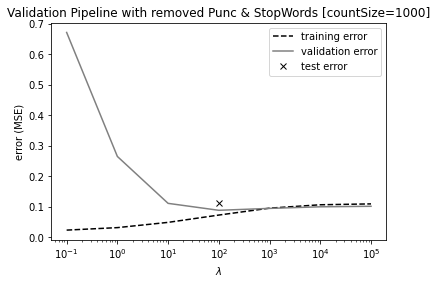

In [160]:
pipeline(1000, True, True)

l = 0.1, validation MSE = 1.0354945226802137
l = 1, validation MSE = 0.309810666103078
l = 10, validation MSE = 0.11374729447010809
l = 100, validation MSE = 0.08839509713988934
l = 1000, validation MSE = 0.09487575962563097
l = 10000, validation MSE = 0.10015272447701781
l = 100000, validation MSE = 0.10183934274781853


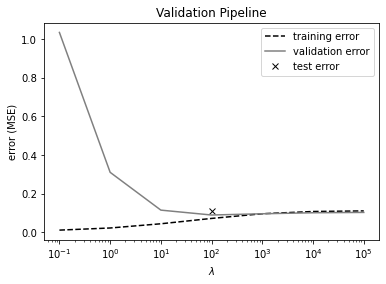

In [157]:
pipeline(2000, False, False)